In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

WARNING    /var/folders/dk/88m9s1b50v53bxqm50d17bjm0000gp/T/ipykernel_87314/1471473820.py:10: RuntimeWarning: invalid value encountered in power
  ttm = 0.1092 * exp(-0.5 * ((vv + 28.71)/25.5)**1.8)
 [py.warnings]


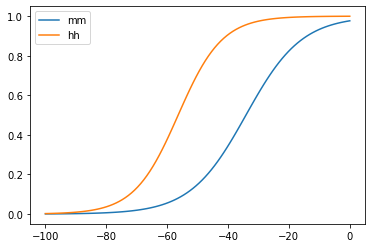

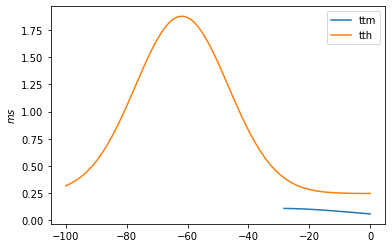

In [2]:
vv = linspace(-100, 0, 100)
mm = 1/(1 + exp((-34.12 - vv)/9.146))
hh = 1/(1 + exp((-56.39 - vv)/7.22))


plot(vv, mm, label='mm')
plot(vv, hh, label='hh')
legend()

ttm = 0.1092 * exp(-0.5 * ((vv + 28.71)/25.5)**1.8)
tth = 0.246 + 1.63 * exp(-0.5 * ((vv + 61.87)/15.25)**2)

figure()
plot(vv, ttm, label='ttm')
plot(vv, tth, label='tth')
ylabel("$ms$")
legend()

In [27]:
%%time
start_scope()

# morphology creation
cyl_len = 50 * umetre
cyl_diam = 50 * umetre
cylinder = Cylinder(length=cyl_len, diameter=cyl_diam, n=1, type="axon")

# consta and parameters
Cm = 1 * ufarad / cm**2
Eleak = -65.5 * mV
Vr = -57.4 * mV
gl = 1.42 * msiemens/cm**2
q10 = 3 ** ((20 - 6.3)/10)  # 20 stands for degree Celsius

gNa_f_max = 25 * msiemens/cm**2
gNa_l1_max = 27 * msiemens/cm**2
gNa_l2_max = 0.128 * msiemens/cm**2

ENa = 62 * mV

gK_max = 1.5 *msiemens/cm**2
EK = -94 * mV

# equations

main_eq = """
Im = gl * (Eleak - v) + INa_f + IK + INa_l1 + INa_l2 : amp/meter**2
I : amp (point current)
"""

Na_f_eq = """
INa_f = gNa_f_max * m_f**3 * h_f * (ENa - v) : ampere/meter**2

dm_f/dt = (m_f_inf - m_f) / tau_m_f : 1
m_f_inf = alpha_m / (alpha_m + beta_m) : 1
tau_m_f = 1*ms / (q10 * (alpha_m + beta_m)) : second  # modelDB version
alpha_m = 1 / exprel(-(v + 34*mV)/10/mV) : 1
beta_m = 4 * exp(-(v + 59*mV)/18/mV) : 1

dh_f/dt = (h_f_inf - h_f) / tau_h_f : 1
alpha_h_f = 0.07 * exp(-(v + 59*mV)/20/mV) : 1
beta_h_f = 1 / (exp(-(v + 29*mV)/10/mV) + 1) : 1
tau_h_f = 1*ms/(q10*(alpha_h_f + beta_h_f)) : second
h_f_inf = alpha_h_f / (alpha_h_f + beta_h_f) : 1
"""
Na_f_eq = Equations(Na_f_eq)
K_eq = """
IK = gK_max * n * (EK - v) : ampere/meter**2
dn/dt = (n_inf - n) / tau_n : 1
alpha_n = .1 / exprel(-(v + 55*mV)/10/mV) : 1
beta_n = 0.125 * exp(-(v + 65*mV)/80/mV) : 1
tau_n = 1*ms / (q10 * (alpha_n + beta_n)) : second
n_inf = alpha_n / (alpha_n + beta_n) : 1
"""
K_eq = Equations(K_eq)
Na_l1_eq = """
INa_l1 = gNa_l1_max * m_l1_inf * h_l1 * (ENa - v) : ampere/meter**2

alpha_m_l1 = 1 / exprel(-(v + 25*mV)/10/mV) : 1
beta_m_l1 = 4 * exp(-(v + 50*mV)/18/mV) : 1
m_l1_inf = alpha_m_l1 / (alpha_m_l1 + beta_m_l1) / q10 : 1

dh_l1/dt = (h_l1_inf - h_l1) / tau_h_l1 : 1
h_l1_inf = 1 / (1 + exp((v + 72.5*mV)/8/mV)) : 1
tau_h_l1 = 0.2218*ms * exp(-0.06883*v/mV) : second
"""
Na_l1_eq = Equations(Na_l1_eq)
Na_l2_eq = """
INa_l2 = gNa_l2_max * m_l2_inf * h_l2 * (ENa - v) : ampere/meter**2
m_l2_inf = 1 / (1 + exp((-51.8*mV - v)/4.6/mV)) : 1
dh_l2/dt = (h_l2_inf - h_l2) / tau_h_l2 : 1
tau_h_l2 = 1*ms / (0.04 * exp(v/25.5/mV)) + 63.2*ms : second
h_l2_inf = 0.9827 / (1 + exp(-((v + 55.67*mV)/(-6.552*mV)))) : 1
"""
Na_l2_eq = Equations(Na_l2_eq)
main_eq = Equations(main_eq) + Na_f_eq + Na_l1_eq + K_eq + Na_l2_eq


# neuron main object
neuron = SpatialNeuron(morphology=cylinder,
                    model=main_eq, Cm=Cm, Ri=35.4*ohm*cm,
                    method="exponential_euler")

# monitors
mon = StateMonitor(neuron, ['v', "m_l1_inf", "h_l1"], record=True)

neuron.v = -70*mV

run(50*ms, report="text")
neuron.I = 3.5 * nA
run(25*ms, report="text")
neuron.I = 0*nA
run(50*ms, report="text")

Starting simulation at t=0. s for a duration of 50. ms
50. ms (100%) simulated in 2s
Starting simulation at t=50. ms for a duration of 25. ms
25. ms (100%) simulated in 1s
Starting simulation at t=75. ms for a duration of 50. ms
50. ms (100%) simulated in 2s
CPU times: user 7min, sys: 7.64 s, total: 7min 7s
Wall time: 7min 47s


Text(0, 0.5, '$V_m$, [mV]')

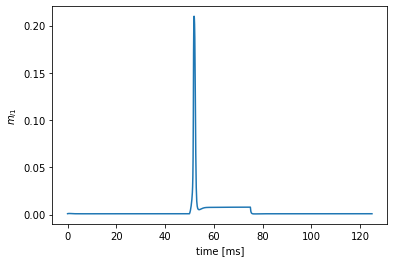

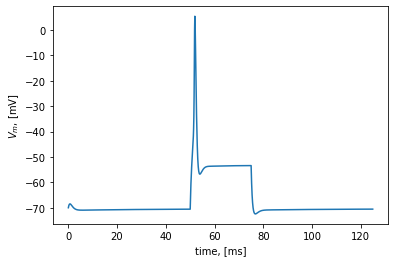

In [26]:
# without Na_l2
plot(mon.t/ms, mon.m_l1_inf[0])
xlabel("time [ms]")
ylabel("$m_{l1}$")

figure()
# result plots without Na_l2
plot(mon.t/ms, mon.v[0]/mV)
xlabel("time, [ms]")
ylabel("$V_m$, [mV]")

Text(0, 0.5, '$m_{l1}$')

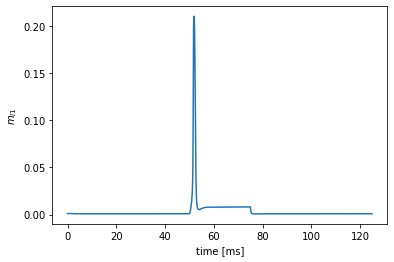

In [28]:
# with Na_l2
plot(mon.t/ms, mon.m_l1_inf[0])
xlabel("time [ms]")
ylabel("$m_{l1}$")

Text(0, 0.5, '$V_m$, [mV]')

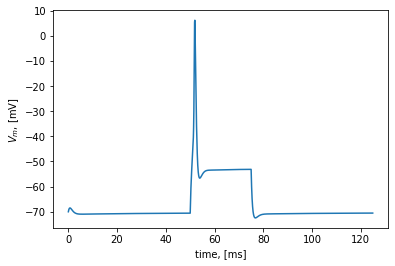

In [29]:
# result plots with Na_l2
plot(mon.t/ms, mon.v[0]/mV)
xlabel("time, [ms]")
ylabel("$V_m$, [mV]")

## supplementary

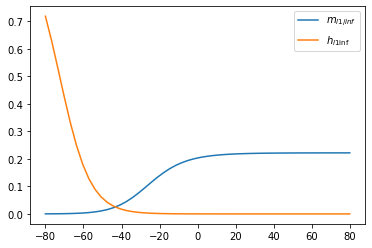

In [6]:
# inter (late1) current

vv = linspace(-80, 80)

alpha_m_l1 = 1 / exprel(-(vv + 25)/10)
beta_m_l1 = 4 * exp(-(vv + 50)/18)
m_l1_inf = alpha_m_l1 / (alpha_m_l1 + beta_m_l1) / q10

h_l1_inf = 1 / (1 + exp((72.5 + vv)/8))


plot(vv, m_l1_inf, label="$m_{l1/inf}$")
plot(vv, h_l1_inf, label="$h_{l1\inf}$")

legend()